# Unsupervised Signature Extraction for Forensic Logs


## Requirements:
* pip3 install -r requirements.txt

## TODO 
* clean and publish rest of experiments

In [1]:
# display ipython notebook full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# autoreloading https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from library.all_imports import * 
from library.helpers import save_to_json, load_from_json, save_to_csv, create_if_not_exists, get_N_HexCol, multiprocess_file
from library.plotting import plot

assert tf.__version__=="1.0.1" # the tensorflow library we used 
tf.set_random_seed(0)
np.random.seed(0) # fix random seed for reproducability
tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow version 1.0.1


# 0 Hyperparameter

In [9]:
from library.all_experiments import * # experiments are defined here

def lib_name(exp_nr):
    if exp_nr in EXPERIMENT_LIB_MAPPING:
        return "data_generation.%s"%EXPERIMENT_LIB_MAPPING[exp_nr]
    else:
        return "data_generation.%s"%ALL_EXPERIMENTS[exp_nr] 
    
experiment_nr = 6 # 6 (unix forensic), 11 (bgl), 13 (spirit2)
EXPERIMENT_ID = ALL_EXPERIMENTS[experiment_nr] # choose data - it will be automatically generated
print("Running experiment: %s"%EXPERIMENT_ID)
EXPERIMENT_SPLIT_TOKEN = SPLIT_TOKEN[experiment_nr] if (experiment_nr in SPLIT_TOKEN.keys()) else SPLIT_TOKEN["default"]

experiment_lib = importlib.import_module(lib_name(experiment_nr))

unknown_token = g.unknown_token = "UNKNOWN_TOKEN"
logline_start_token = g.logline_start_token = "LOG_START"
logline_end_token = g.logline_end_token= "LOG_END"
pad_token = g.pad_token = "PAD_TOKEN"
g.vocabulary_max_lines = -1 # -1 means unlimited
g.max_line_len = 200

# define names
run_tag = "m-pn"
model_name = "rnn-autoencoder"

# clustering 
cluster_alg="birch" # alternatives:  birch hierarch dbscan  
fold_times = 10 

# create experiment directories
result_dir = "results"
experiment_dir = "%.2d_%s"%(experiment_nr,EXPERIMENT_ID)
experiment_outdir = join_path(result_dir, experiment_dir ,  now_str )
checkpoint_path = join_path(experiment_dir , "graph", run_tag)
graph_dir = join_path(experiment_outdir,"graph",run_tag)

create_if_not_exists(checkpoint_path)
create_if_not_exists(graph_dir)

# data files

datafile = g.datafile =  "data/%s.log"%EXPERIMENT_ID
labels_true_file = "data/%s.ids"%EXPERIMENT_ID
processed_datafile = join_path(result_dir, experiment_dir,"%s_log.processed"%EXPERIMENT_ID)  
VOCABULARY_FILE = g.VOCABULARY_FILE = join_path(result_dir, experiment_dir, "vocabulary.json")
HYPERPARAMETERS_FILE = join_path(experiment_outdir, "hyperparams.json")
CLUSTERING_RESULTS_FILE = join_path(experiment_outdir, "clustering_results.csv")
learned_weights_file = join_path(experiment_outdir,"learned_weights.csv")
DATASET_STATS_FILE = join_path(result_dir, experiment_dir, "dataset_statistics.json")                                

#
g.REGENERATE_VOCABULARY_FILES = True    
g.REPROCESS_TRAININGS_DATA  = True
learn_model = True

Running experiment: unix_log


# Generate vocabulary

To generate our vocabulary, we perform the following steps:
* tokenize the log lines of the data file
* create Vocabulary from tokenized loglines, count word frequencies 
* create index_to_word and word_to_index dictionary
* replace unknown words with an UNK token (not relevant for us now)

If you need to see which steps are taken, have a look at  library.vocabulary.py


In [10]:
g.WORD_TO_INDEX_FILE = join_path(result_dir, experiment_dir, "word_to_index.json")
g.INDEX_TO_WORD_FILE = join_path(result_dir, experiment_dir, "index_to_word.json")
g.TOKENIZED_LOGLINES_FILE = join_path(result_dir, experiment_dir, "tokenized_loglines.json")
g.SPLIT_TOKEN = EXPERIMENT_SPLIT_TOKEN

# g.SPLIT_TOKEN = ['"']
from library.vocabulary import *
print("Dataset fully loaded")       

Dataset fully loaded


# Datset statistics

sorted words
('', ':', ']', '[', '.', '0', 'kernel', '/', '-', '\n', 'pid', '_', '=', '1', ')', '(', '000000', '"', 'systemd', "'", '00', 'networkmanager', '<info>', 'pci', '0000', 'device', 'acpi', '2', '4', '00000000', 'daemon', 'for', 'to', 'bus', 'started', 'mem', 'type', 'of', 'system', 'lib', 'starting', 'apparmor', 'enp0s3', '0d', 'usr', 'usb', '5', 'manager', '572', '582', '585', 'user', 'loaded', 'plugin', '1466518545', '3', 'on', 'is', 'service', 'session', '1467205191', 'version', 'not', 'audit', 'pam', 'io', 'state', 'registered', 'org', 'snapd', 'by', 'devices', 'the', 'using', 'target', 'max', 'profile', 'no', 'name', 'in', 'ebx', 'eax', 'reg', 'ecx', 'edx', 'cpuid', '00000000\n', 'lightdm', '1466518840', 'found', 'new', 'x86', 'cpu', 'driver', 'input', '10', '64', 'generic', 'entries', 'table', 'initializing', '0\n', 'memory', 'bytes', 'adding', 'hash', 'at', 'irq', 'root', 'order', 'load', 'and', 'reached', 'file', 'rtkit', 'c', 'ohci', 'e820', 'subsys', '01', 'freedesk

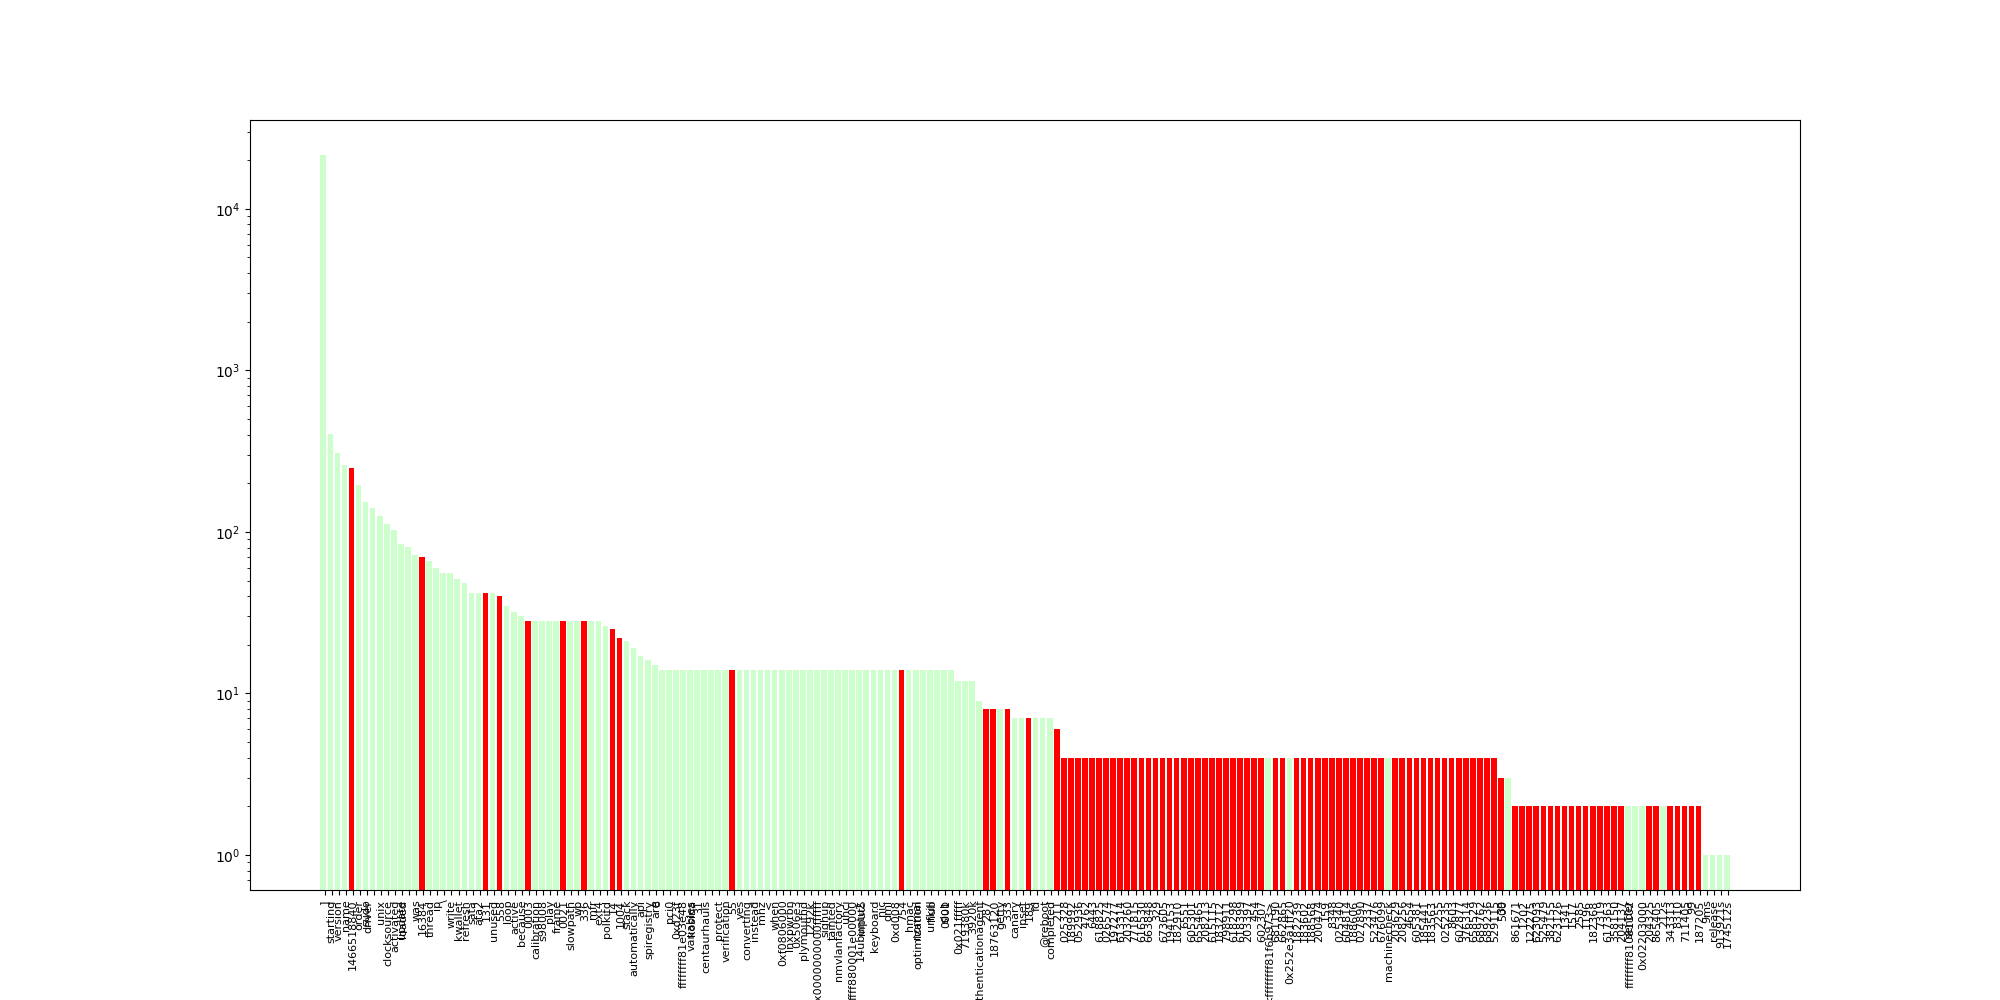

In [11]:
#for w in sorted(word_frequencies.iteritems(), key= lambda x:x[1], reverse=True):
del word_frequencies["LOG_START"]
del word_frequencies["LOG_END"]
#    print(w)

words,frequencies = zip(*sorted(word_frequencies.items(), key= lambda x:x[1], reverse=True))
print("sorted words")
print(words[0:200])

total_words = len(words)
stratify_parts = 200

stratum_length = total_words/stratify_parts

indices = []

for i in range(stratify_parts):    
    strat_start = i* stratum_length
    strat_end = (i+1) * stratum_length -1   
    new_index = np.random.randint(strat_start, strat_end)
#    print(strat_start, strat_end, new_index)
    indices.append(new_index)
    
words = np.array(words)[indices]
frequencies = np.array(frequencies)[indices]

print("Sorted words.")

words = [str(w) for w in words]
colors = []
for w in words:
    if w.isdigit():
        colors.append("r")# "#ffcccc" light red      
    else:
        colors.append("#ccffcc") #light green
print("Defined colors")
        
cluster_plot_file = join_path(result_dir,experiment_dir, "dataset_stats.png")
figure_size=(20,10) 
fig = plt.figure(figsize=figure_size)

index = np.arange(len(words))
bar_width = 0.35


ax1 = fig.add_subplot(111)
ax1.bar(index, frequencies,  color=colors)
ax1.set_yscale('log')
plt.xticks(index + bar_width / 2, (words), rotation=90, fontsize = 8)
plt.savefig(cluster_plot_file)
plt.close()

Image(filename=cluster_plot_file) 

# Average LogLine Length

In [12]:
line_lengths = []
for logline in tokenized_loglines: 
    line_lengths.append(len(logline))

In [13]:
np.average(line_lengths)

35.953551664701081

# 1.3 Process trainingsdata

In [14]:
# Create the training data
if g.REPROCESS_TRAININGS_DATA: 
    X_train = np.asarray([[word_to_index[w] for w in logline] for logline in tokenized_loglines])
    maximum_sequence_length =-1
    train_numbers_file = open(processed_datafile,"w")
    one_percent = len(X_train)/100
    for i, logline_as_word_id_sequence in enumerate(X_train):
        if i%one_percent==0: print("Written line %i"%i)
        #print ",".join(line)

        reversed_seq = list(reversed(logline_as_word_id_sequence))
        # add sequence length to example

        sequence_length = str(len(logline_as_word_id_sequence))
        if len(logline_as_word_id_sequence)>maximum_sequence_length: maximum_sequence_length=len(logline_as_word_id_sequence) # find maximum sequence length
        word_id_seq = ",".join(map(str,logline_as_word_id_sequence)) # encoder input: 1,2,3 
        word_id_seq_reversed = ",".join(map(str,reversed_seq)) # decoder input: 3,2,1 
        target_seq = ",".join(map(str, reversed_seq[1:]+[PAD_ID])) # decoder target: 2,1,PAD 

        signature_id = experiment_lib.extract_pattern_id(loglines[i])
        assert not signature_id==0,"Each log line has to be associated to one signature, none for (%s). Check extract_pattern_id method."%loglines[i]
        # write      
        train_numbers_file.write("%s|%s|%s|%s|%s\n"%(signature_id, sequence_length, word_id_seq,word_id_seq_reversed,target_seq))

    train_numbers_file.close()
else:
    X_train = np.asarray([[word_to_index[w] for w in logline] for logline in tokenized_loglines])
    print("Trainingsdata has already been processed")

if not os.path.exists(labels_true_file):
    os.system("python3 create_true_labels.py -en %s"%EXPERIMENT_ID)

Written line 0


# 2.0  Graph Hyper parameters

In [17]:
# TDB save vocabulary file
state_size = 256 # size of vector internal of a cell
batch_size = 200

num_examples_to_visualize = min(10000, len(tokenized_loglines)) # how many dots to show
num_examples_to_embed = len(tokenized_loglines)

dropout_keep_probability = 0.7
num_lstm_layers = 1

DTYPE=tf.float32
num_samples = min(vocabulary_size, 500) # number of samples to draw for sampled softmax
max_gradient_norm = 0.5 # to be defined

LEARNING_RATE = 0.02
learning_rate_decay_factor = 0.95
l1_scale= 0.000
epochs = 10

num_examples = len(X_train)
max_steps = int(epochs * (num_examples / batch_size))
learning_rate_adjustments = 10 # how many times to apply learning rate decay over all epochs
adjust_learning_rate_after_steps = max_steps / learning_rate_adjustments

# some tf varioables
tf_keep_probabiltiy = tf.constant(dropout_keep_probability) 
tf_global_step = tf.Variable(0, trainable=False)


# clustering hierarchy
examples_in_hierarchy = 50
color_threshhold = 0.2

# threshold for vmeasure, homogenity etc.
h_threshold = 0.004

# save hyperparameters
hyperparams = {
    "state_size":state_size,
    "num_examples_to_visualize":num_examples_to_visualize,
    "dropout_keep_probability":dropout_keep_probability,
    "num_lstm_layers":num_lstm_layers,
    "learning_rate_decay_factor":learning_rate_decay_factor,
    "batch_size":batch_size,
    "dtype":str(DTYPE),
    "num_samples":num_samples,
    "max_gradient_norm":max_gradient_norm,
    "learning_rate":LEARNING_RATE,
    "epochs":epochs,
    "num_examples":num_examples,
    "max_steps":max_steps,
    "examples_in_hierarchy":examples_in_hierarchy,
    "color_threshhold":color_threshhold,    
    "h_threshold":h_threshold,
}


save_to_json(hyperparams, HYPERPARAMETERS_FILE)

Saved to json: results/06_unix_log/20171002-15-50/hyperparams.json.


#  2 Graph

## Learning Rate

In [18]:
# https://www.tensorflow.org/versions/master/api_docs/python/tf/train/exponential_decay

learning_rate = tf.train.exponential_decay(
  learning_rate=LEARNING_RATE, 
  global_step=tf_global_step, # current learning step
  decay_steps= adjust_learning_rate_after_steps, # how many steps to train after decaying learning rate      
  decay_rate=learning_rate_decay_factor,                
  staircase=True)


## 2.1 Input, Output and Target of the graph

In [19]:

# inputs, outputs
x_e = tf.placeholder(tf.int32, [batch_size, None]) # encoder inputs loglines [batch_size, num_steps]
x_d = tf.placeholder(tf.int32, [batch_size, None]) # decoder inputs 
y_d = tf.placeholder(tf.int32, [batch_size, None]) # reversed loglines [batch_size, num_steps]

visualization_embeddings = tf.Variable(np.zeros([num_examples_to_visualize, state_size]) , trainable=False, name="VisualizationEmbeddings", dtype= DTYPE   )

word_embeddings = tf.get_variable('word_embeddings', [vocabulary_size, state_size], dtype= DTYPE ) # each row is a dense vector for each word.

# Encoder Inputs
encoder_inputs = tf.nn.embedding_lookup(word_embeddings, x_e) # [batch_size, max_time, embedding_size]
encoder_sequence_lengths = tf.placeholder(tf.int32, [batch_size]) # [batch_size]

# Decoder Inputs
decoder_inputs = tf.nn.embedding_lookup(word_embeddings, x_d) # need to be defined  [batch_size, max_time, embedding_size]
decoder_sequence_lengths = tf.placeholder(tf.int32, [batch_size]) # [batch_size]

# Decoder Labels
decoder_labels = y_d # this are our target words

## LSTM, Dropout Wrapper, MultiRNNCell

* https://github.com/tensorflow/tensorflow/blob/v1.0.0-rc0/tensorflow/contrib/rnn/python/ops/core_rnn_cell.py
* https://github.com/tensorflow/tensorflow/blob/v1.0.0-rc0/tensorflow/contrib/rnn/python/ops/lstm_ops.py
* https://github.com/tensorflow/tensorflow/blob/v1.0.0-rc0/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py

* prepare attention states - concatenate output states. 
* this is the "old" way of doing things, mayb
* top_states = [array_ops.reshape(e, [-1, 1, encoder_cell.output_size]) for e in encoder_outputs]
* attention_states = array_ops.concat(1, top_states)

In [20]:
from library.core_rnn_cell_impl import DropoutWrapper as DtypeDropoutWrapper # import v1.1.0 dropout wrapper to support setting DTYPE to half-precision

# Define cells
with tf.variable_scope("encoder_scope") as encoder_scope:

    cell = contrib_rnn.LSTMCell(num_units=state_size, state_is_tuple=True)
    cell = DtypeDropoutWrapper(cell=cell, output_keep_prob=tf_keep_probabiltiy, dtype=DTYPE)
    cell = contrib_rnn.MultiRNNCell(cells=[cell] * num_lstm_layers, state_is_tuple=True)

    encoder_cell = cell # needs to be defined

    # encode inputs
    encoder_outputs, last_encoder_state = tf.nn.dynamic_rnn(
        cell=encoder_cell,
        dtype=DTYPE,
        sequence_length=encoder_sequence_lengths,
        inputs=encoder_inputs,
        )

## 2.5 Dynamic RNN decoder

* https://github.com/tensorflow/tensorflow/blob/v0.12.0/tensorflow/python/ops/seq2seq.py 
* decoder https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/seq2seq.py
* legacy attention decoder https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/legacy_seq2seq/python/ops/seq2seq.py
* https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/python/ops/rnn.py
* https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/contrib/seq2seq/python/ops/seq2seq.py
* OuputProjectionWrapper https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L389

In [21]:
# decoder_outputs = [batch_size, max_time, cell.output_size]
# final_state = [batch_size, cell.state_size]
# final_context_state
with tf.variable_scope("decoder_scope") as decoder_scope:
        # output projection
    # we need to specify output projection manually, because sampled softmax needs to have access to the the projection matrix 
    output_projection_w_t = tf.get_variable("output_projection_w", [vocabulary_size, state_size], dtype=DTYPE)
    output_projection_w = tf.transpose(output_projection_w_t)
    output_projection_b = tf.get_variable("output_projection_b", [vocabulary_size], dtype=DTYPE)
    
    # define decoder cell
    decoder_cell = tf.contrib.rnn.LSTMCell(num_units=state_size)
    decoder_cell = DtypeDropoutWrapper(cell=decoder_cell, output_keep_prob=tf_keep_probabiltiy, dtype=DTYPE)
    decoder_cell = contrib_rnn.MultiRNNCell(cells=[decoder_cell] * num_lstm_layers, state_is_tuple=True)   
    # decoder_cell = contrib_rnn.OutputProjectionWrapper(decoder_cell, output_size=vocabulary_size ) # rnn output: [batch_size, max_time, vocabulary_size ]

    # define decoder train netowrk
    decoder_outputs_tr, _ , _ = dynamic_rnn_decoder( # decoder outputs, final hidden state, final context state
        cell=decoder_cell, # the cell function
        decoder_fn= simple_decoder_fn_train(last_encoder_state, name=None),
        inputs=decoder_inputs, # [batch_size, max_time, embedding_size].
        sequence_length=decoder_sequence_lengths, #  length for sequence in the batch [batch_size] 
        parallel_iterations=None, # Tradeoff - time for memory
        swap_memory=False,
        time_major=False)
    
    # define decoder inference network
    decoder_scope.reuse_variables()    
    

# 3 Objective and Optimization

* https://github.com/tensorflow/tensorflow/blob/v1.0.0-rc0/tensorflow/python/ops/nn_impl.py

* The output projection maps from the dimension of the output vector of the LSTM to the vocabualry size.  
* The labels come in as matrix [batch_size, time_steps]. 
* The labels are integers, and denote the row_id of a word in the word embedding. 
* The labels are transformed to the shape: [batchsize*timesteps, 1] to perform the sampled softmax. 
* The sampled_softmax_function performs the one-hot encoding of the labels.

* Logits are just the outputs of a layer (i.e., sigmoid, tanh...) WITHOUT being squashed by a softmax function
* Explanation of logits.  https://stackoverflow.com/questions/36078411/tensorflow-are-my-logits-in-the-right-format-for-cross-entropy-function

* sparse_softmax_cross_entropy_with_logits  https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/python/ops/nn_ops.py#L1637

*  https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/contrib/seq2seq/python/ops/loss.py
* https://www.tensorflow.org/extras/candidate_sampling.pdf

## 3.1 Loss function

In [22]:
print("Decoder Output  Shape: [batch_size=%s, max_timesteps=%s, vocabulary_size=%s]"%tuple(decoder_outputs_tr.shape))
#from library.nn_impl import sampled_softmax_loss as dtype_sampled_softmax_loss # imported cutom loss function to support dtype  as a parameter => half precision

# reshape outputs of decoders to [ batch_size * max_time , vocabulary_size ]
decoder_forward_outputs = tf.reshape(decoder_outputs_tr,[-1, state_size])
decoder_target_labels  = tf.reshape(decoder_labels ,[-1, 1])# =>  [ batch_size * max_time ]  sequence of correc tlabel

sampled_softmax_losses = tf.nn.sampled_softmax_loss(
    weights = output_projection_w_t,# [num_classes, state_size]
    biases = output_projection_b, # [num_classes]
    inputs = decoder_forward_outputs, #  inputs: A `Tensor` of shape `[batch_size, state_size]`.  The forward activations of the input network. 
    labels = decoder_target_labels , 
    num_sampled = num_samples,
    num_classes=vocabulary_size,
    num_true = 1,
)    
total_loss_op = tf.reduce_mean(sampled_softmax_losses) 


Decoder Output  Shape: [batch_size=200, max_timesteps=?, vocabulary_size=256]


## Regularization

In [23]:
l1_regularizer = tf.contrib.layers.l1_regularizer(
    scale=l1_scale, scope=None
)
weights = tf.trainable_variables()
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, [word_embeddings])

regularized_loss = total_loss_op + regularization_penalty

INFO:tensorflow:Scale of 0 disables regularizer.


## Trainings step

In [24]:
# get gradients for all trainable parameters with respect to our loss funciton
params = tf.trainable_variables()
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
gradients = tf.gradients(regularized_loss, params)

# apply gradient clip
clipped_gradients, gradient_norm = tf.clip_by_global_norm(gradients,max_gradient_norm)

# Update operation
training_step  = optimizer.apply_gradients(zip(clipped_gradients, params), global_step=tf_global_step) # learing rate decay is calulated based on this step

# 4 Training 

## Prepare Batch Loading for trainings data

In [25]:
# load single example from processed file
filename_queue = tf.train.string_input_producer([processed_datafile], num_epochs=None) # num_epochs=None 
reader = tf.TextLineReader()
example_id, single_example_logline = reader.read(filename_queue) 

In [26]:
# define how to parse single example (see 1.3)
split_example = tf.string_split([single_example_logline],delimiter="|")
split_example_dense = tf.sparse_tensor_to_dense(split_example, default_value='', validate_indices=True, name=None)
split_example_dense = split_example_dense[0]

In [27]:
# split_example_dense[0] is signature id
# sequence length
sequence_length=tf.string_to_number(split_example_dense[1],out_type=tf.int32)
# split encoder inputs
enc_split =  tf.string_split([split_example_dense[2]],delimiter=",")
enc_split_dense = tf.sparse_tensor_to_dense(enc_split, default_value='', validate_indices=True, name=None)
x_e_single = tf.string_to_number(enc_split_dense, out_type=tf.int32)    
# split decoder inputs
dec_split =  tf.string_split([split_example_dense[3]],delimiter=",")
dec_split_dense = tf.sparse_tensor_to_dense(dec_split, default_value='', validate_indices=True, name=None)
x_d_single = tf.string_to_number(dec_split_dense, out_type=tf.int32)  
# split decoder targets
tar_split =  tf.string_split([split_example_dense[4]],delimiter=",")
tar_split_dense = tf.sparse_tensor_to_dense(tar_split, default_value='', validate_indices=True, name=None)
y_single = tf.string_to_number(tar_split_dense, out_type=tf.int32)  

In [28]:
# Batch the variable length tensor with dynamic padding
fetch_trainings_batch = tf.train.batch(
    tensors=[
        x_e_single[0], #single encoder input line
        x_d_single[0], #single decoder input line 
        y_single[0], #single decoder target line  
        sequence_length,   # sequence length of this example
    ],
    batch_size=batch_size,
    dynamic_pad=True,
    name="trainings_batch",
    allow_smaller_final_batch=True
)

# 4.1 Session Setup

* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/data_flow_ops.py
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard8/tf.train.batch.md
* https://www.tensorflow.org/how_tos/summaries_and_tensorboard/

In [29]:
def get_batch_dict(session):
    # get trainingsbatch from input queue
    batch = session.run([fetch_trainings_batch], feed_dict=None)
    batch = batch[0] 
        
    # assign arrays to dictionary
    batch_dict = {
        x_e:batch[0], # encoder inputs 
        x_d:batch[1], # decoder inputs
        y_d:batch[2], # decoder targets
        encoder_sequence_lengths:batch[3], 
        decoder_sequence_lengths:batch[3]           
    }
    return batch_dict

# 4.2  Trainings Loop

In [34]:
if learn_model:    
    current_epoch = 0
    save_checkpoint_after_each_step = int(max_steps/10)
    print_loss_after_steps = int(max_steps/100)

    queue_capacity = 2 * batch_size

    # Saver
    saver = tf.train.Saver(tf.global_variables())

    # Summaries
    tf.summary.scalar("total_loss",tf.cast(total_loss_op, DTYPE)) # summary for accuracy
    tf.summary.scalar("regularized_loss",tf.cast(regularized_loss, DTYPE)) # summary for accuracy
    # Start session
    session = tf.Session()

    # Check random seed for reproducability
    control_random_number = session.run(tf.random_normal([1])) 
    print("Control Random Number: %0.5f"%control_random_number) # should change if you modify the graph

    
    all_summaries = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(graph_dir, graph=session.graph)

    session.run([
            tf.local_variables_initializer(),
            tf.global_variables_initializer(),
        ])


Control Random Number: 1.44609


In [36]:
s= time.time() # start time
if learn_model:

    word_embeddings_before = session.run(word_embeddings)
    import collections
    batch_times = collections.deque()


    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=session, coord=coord)

    for current_step in range(1,max_steps+1): # start from 1 .. max_steps+1 to execute max steps            

        try:
            step_s = time.time()
            # increase step counter
            session.run(tf_global_step.assign(current_step)) 

            # get next batch
            batch_dict=get_batch_dict(session)
            # execute actions
            results = session.run([
                total_loss_op, # calculate training loss
                regularized_loss, #     
                training_step, # calculate gradients, update gradients
                all_summaries, # compile summaries and write to graph dir,
                learning_rate,
                 # get gradients    
            ], feed_dict = batch_dict )

            summary_writer.add_summary(results[3],current_step)
            batch_times.append( (time.time()-step_s))

        except Exception as e:
            # Report exceptions to the coordinator.
            print("Aborting trainingsloop :%s"%str(e.message))
            coord.request_stop(e)
            break

        if current_step % print_loss_after_steps==0:
            print("Epoch {epoch:02d}, Step {current_step:05d}/{max_steps:05d}, Current Learning rate: {learning_rate:0.4f},  Loss: {loss:0.4f} Regularized Loss: {regularized_loss:0.4f}".format(
                    epoch=int(current_step/(max_steps/epochs)+1), 
                    current_step=current_step, max_steps=max_steps,
                    learning_rate=results[4], 
                    loss=results[0],regularized_loss=results[1]
                )# end format
            ) # end print
            avg_batch_time =  sum(batch_times) /len(batch_times)
            total_time_in_s = avg_batch_time * max_steps
            print("Average step time: %0.2fs, Estimated total duration: ~%0.2f min (~ %0.2f h) "% (avg_batch_time, total_time_in_s/60.0, total_time_in_s/3600.0 ))

        # save checkpoint every xth step
        if current_step % save_checkpoint_after_each_step==0:
            print ("Saving checkpoint")

            chkpoint_out_filename = join_path(checkpoint_path, model_name)
            saver.save(session, chkpoint_out_filename , global_step=current_step)             

    # stop training queues
    coord.request_stop()    
    word_embeddings_after = session.run(word_embeddings)
    e = time.time()
    print("Learning took {sec:0.2f} seconds".format(sec=(e-s)))
else:
    current_step = 35821 # TODO this needs to be adjusted 
    
    session = tf.Session()
    meta_data = join_path(result_dir, checkpoint_path,'rnn-autoencoder-35821.meta') # TODO this needs to be adjusted 
    print(meta_data)
    saver = tf.train.Saver()#tf.train.import_meta_graph(meta_data)
    print("Restored graph")
    model_to_load  =  tf.train.latest_checkpoint( join_path( result_dir, checkpoint_path))
    print("Load '%s' from saved checkpoints"%model_to_load)            
    saver.restore(session, model_to_load)

Epoch 01, Step 00005/00551, Current Learning rate: 0.0200,  Loss: 8.2411 Regularized Loss: 8.2411
Average step time: 0.40s, Estimated total duration: ~3.63 min (~ 0.06 h) 
Epoch 01, Step 00010/00551, Current Learning rate: 0.0200,  Loss: 8.1466 Regularized Loss: 8.1466
Average step time: 0.38s, Estimated total duration: ~3.44 min (~ 0.06 h) 
Epoch 01, Step 00015/00551, Current Learning rate: 0.0200,  Loss: 8.0874 Regularized Loss: 8.0874
Average step time: 0.36s, Estimated total duration: ~3.30 min (~ 0.05 h) 
Epoch 01, Step 00020/00551, Current Learning rate: 0.0200,  Loss: 8.0343 Regularized Loss: 8.0343
Average step time: 0.35s, Estimated total duration: ~3.23 min (~ 0.05 h) 
Epoch 01, Step 00025/00551, Current Learning rate: 0.0200,  Loss: 7.8759 Regularized Loss: 7.8759
Average step time: 0.35s, Estimated total duration: ~3.19 min (~ 0.05 h) 
Epoch 01, Step 00030/00551, Current Learning rate: 0.0200,  Loss: 7.9663 Regularized Loss: 7.9663
Average step time: 0.34s, Estimated total 

Epoch 05, Step 00245/00551, Current Learning rate: 0.0163,  Loss: 2.8341 Regularized Loss: 2.8341
Average step time: 0.35s, Estimated total duration: ~3.25 min (~ 0.05 h) 
Epoch 05, Step 00250/00551, Current Learning rate: 0.0163,  Loss: 3.2582 Regularized Loss: 3.2582
Average step time: 0.35s, Estimated total duration: ~3.24 min (~ 0.05 h) 
Epoch 05, Step 00255/00551, Current Learning rate: 0.0163,  Loss: 2.4136 Regularized Loss: 2.4136
Average step time: 0.35s, Estimated total duration: ~3.23 min (~ 0.05 h) 
Epoch 05, Step 00260/00551, Current Learning rate: 0.0163,  Loss: 2.3897 Regularized Loss: 2.3897
Average step time: 0.35s, Estimated total duration: ~3.24 min (~ 0.05 h) 
Epoch 05, Step 00265/00551, Current Learning rate: 0.0163,  Loss: 3.6174 Regularized Loss: 3.6174
Average step time: 0.35s, Estimated total duration: ~3.25 min (~ 0.05 h) 
Epoch 05, Step 00270/00551, Current Learning rate: 0.0163,  Loss: 2.9258 Regularized Loss: 2.9258
Average step time: 0.35s, Estimated total 

Epoch 09, Step 00485/00551, Current Learning rate: 0.0133,  Loss: 1.0046 Regularized Loss: 1.0046
Average step time: 0.36s, Estimated total duration: ~3.27 min (~ 0.05 h) 
Epoch 09, Step 00490/00551, Current Learning rate: 0.0133,  Loss: 0.9198 Regularized Loss: 0.9198
Average step time: 0.36s, Estimated total duration: ~3.27 min (~ 0.05 h) 
Epoch 09, Step 00495/00551, Current Learning rate: 0.0133,  Loss: 1.0452 Regularized Loss: 1.0452
Average step time: 0.36s, Estimated total duration: ~3.27 min (~ 0.05 h) 
Saving checkpoint
Epoch 10, Step 00500/00551, Current Learning rate: 0.0126,  Loss: 0.7290 Regularized Loss: 0.7290
Average step time: 0.36s, Estimated total duration: ~3.27 min (~ 0.05 h) 
Epoch 10, Step 00505/00551, Current Learning rate: 0.0126,  Loss: 0.9930 Regularized Loss: 0.9930
Average step time: 0.36s, Estimated total duration: ~3.28 min (~ 0.05 h) 
Epoch 10, Step 00510/00551, Current Learning rate: 0.0126,  Loss: 1.0692 Regularized Loss: 1.0692
Average step time: 0.36s

NameError: name 's' is not defined

# 5 Visualization


* https://colah.github.io/posts/2015-01-Visualizing-Representations/
* https://github.com/normanheckscher/mnist-tensorboard-embeddings/blob/master/mnist_t-sne.py
* https://www.tensorflow.org/how_tos/embedding_viz/


# Embedd all loglines

In [40]:
memmap_file = join_path(result_dir, experiment_dir,"embedded_lines.mem")
embedded_loglines = np.ndarray(shape=[num_examples_to_embed, state_size])

if not os.path.exists(memmap_file):
    # load 
    trainings_examples = list(open(processed_datafile,"r"))
    trainings_examples = [t.split("|") for t in trainings_examples]
    print("Loaded trainingsdata")

    s = time.time()
    count = 0
    train_batches  =  list(range(0, num_examples_to_embed, batch_size))
    print("Started embedding %i batches of %i log lines"%(len(train_batches),num_examples_to_embed ))
    for i, ex_id in enumerate(train_batches):
        if (i+1)%(int(len(train_batches)/20))==0:
            print ("Embedded %0.2f ercent of batches"%(100*i/float(len(train_batches))))
        x_e_batch = []
        esl_batch = []

        incomplete_batch = False # for last batch
        incomplete_length = 0
        # get batch, write metadata
        for b_id, example in enumerate(trainings_examples[ex_id:ex_id+batch_size]):
            count+=1
            esl_batch.append(int(example[1])) # sequence length
            x_e_batch.append(np.array(example[2].split(","),dtype=np.integer) ) # encoder input

        if len(x_e_batch)<batch_size: # last_batch, so need to zero add id
            incomplete_batch=True
            incomplete_length = len(x_e_batch)

            for _ in range(batch_size-len(x_e_batch)):
                esl_batch.append(0)
                x_e_batch.append(np.zeros([len(x_e_batch[0])]))

        # pad batch
        max_seq_len = np.amax(esl_batch) # maximum encoder length
        padded_x_e_batch = []
        for x_es in x_e_batch:
            padded_x_e = np.pad(x_es , (0,max_seq_len-len(x_es)), 'constant', constant_values=0)
            padded_x_e_batch.append(padded_x_e)                          

        #assign arrays to dictionary
        batch_dict = {
            x_e:np.array(padded_x_e_batch), # encoder inputs  # [batch_size, max_sequence_length, state_size ]
            encoder_sequence_lengths:np.array(esl_batch) # encoder sequence length [batch_size,1]           
        }

        # execute actions
        results = session.run([
            last_encoder_state, # get encoded trainings samples
        ], feed_dict = batch_dict )

        # story in temporary array
        if incomplete_batch:
            embedded_loglines[ex_id:ex_id+incomplete_length,] = results[0][0].c[0:incomplete_length]
        else:
            embedded_loglines[ex_id:ex_id+batch_size,] = results[0][0].c # copy c hidden state to tmp_ary


    print("Embedded %i lines in ~%0.2f min"%(num_examples_to_embed, ((time.time()-s )/60.0)))
    fp = np.memmap(memmap_file, dtype='float32', mode='w+', shape=(num_examples_to_embed,state_size))
    fp[:]=embedded_loglines[:]
    fp.flush()
    print("Saved embedded lines to file: %s "%memmap_file)
else:
    fp = np.memmap(memmap_file, dtype='float32', mode='r', shape=(num_examples_to_embed,state_size))
    print("Loaded embedded lines to file: %s "%memmap_file)

    embedded_loglines[:]=fp[:]
X = embedded_loglines

Loaded embedded lines to file: results/06_unix_log/embedded_lines.mem 


# Homogenity, Completeness, V-Measure


In [42]:
s = time.time()
import multiprocessing
import sklearn
from multiprocessing import Pool, Manager
import traceback

min_thres = 0.1
max_thres = 10 
thres_step = 0.5
thresholds = list(np.arange(min_thres,max_thres,thres_step))
title_row = ["Threshold", "Homogenity", "Completeness", "V-Measure", "Mutual Info", "Adj. Mut. Inf", "Shill",  "HOM std", "COM std", "VME std", "MI std", "AMI std" , "Shill std"]
manager = Manager()
cluster_results = manager.list([[]] * len(thresholds) )
                    
labels_true = np.array(list(open(labels_true_file)))


limit = 10000


def cluster_t(row_threshold):
    i,threshold = row_threshold # unpack arguments
    
    row = manager.list(cluster_results[i]) # get shared list
    
    try:
        if cluster_alg=="minibatch-kmeans":
            mbkm = sklearn.cluster.MiniBatchKMeans(n_clusters=threshold, batch_size=2000 )
            labels_predicted = mbkm.fit_predict(X)
        
            hom_com_vmes = metrics.homogeneity_completeness_v_measure(labels_true, labels_predicted)
            row.append(threshold)
            row+=list(hom_com_vmes)
            row.append(metrics.mutual_info_score(labels_true, labels_predicted, contingency=None))
            row.append(metrics.adjusted_mutual_info_score (labels_true, labels_predicted) ) 
        else:
            subsample_indizes = list(range(len(X)))
            subsample_rows = []
            
            row.append(threshold)
            
            for ss in range(fold_times):        
                np.random.shuffle(subsample_indizes)              
                indizes = subsample_indizes[:limit]                
                sub_sample = X[indizes]
                sub_sample_true_labels = labels_true[indizes]
                
                subsample_row = []
                
                if cluster_alg=="hierarch":    
                    labels_predicted = hierarchy.fclusterdata(sub_sample, threshold ,depth=4, criterion="distance", metric="euclidean", method="complete") 
                elif cluster_alg=="dbscan":
                    dbscan = sklearn.cluster.DBSCAN(eps=threshold) 
                    labels_predicted = dbscan.fit_predict(sub_sample)
                elif cluster_alg=="birch":
                    clusterer = sklearn.cluster.Birch(threshold=threshold, branching_factor=50, n_clusters=None, compute_labels=True, copy=True)
                    labels_predicted = clusterer.fit_predict(sub_sample)
                else:
                    0/0
                
                hom_com_vmes = metrics.homogeneity_completeness_v_measure(sub_sample_true_labels, labels_predicted)
                shilloutte = sklearn.metrics.silhouette_score(sub_sample, sub_sample_true_labels)
                
                subsample_row+=list(hom_com_vmes)
                subsample_row.append(metrics.mutual_info_score(sub_sample_true_labels, labels_predicted, contingency=None))
                subsample_row.append(metrics.adjusted_mutual_info_score (sub_sample_true_labels, labels_predicted) ) 
                subsample_row.append(shilloutte)
                
                subsample_rows.append(subsample_row)
                
            row+=list(np.average(subsample_rows, axis=0))
            row+=list(np.std(subsample_rows, axis=0))
            print(row)
           
        #row.append(shilloutte)

        cluster_results[i] = row # assign shared list

        finished = 0
        for cr in cluster_results:
            if len(cr)>0:
                finished+=1

        if i%(len(cluster_results)/20.0)==0: 
            print("%i/%i thresholds finished."%(finished,len(cluster_results)))
    except Exception as e:
        print(e)
        traceback.print_exc()
    

# creat clusterjobs
print("Started %i processing tasks, with %i folds and %i sample size"%(len(thresholds),fold_times, limit))
pool = Pool(processes=min(7,len(thresholds))) # start 6 worker processes
pool.map(cluster_t, [(i, threshold) for i, threshold in enumerate(thresholds)])
pool.close()
pool.join()          

save_to_csv([title_row] + list(cluster_results) , CLUSTERING_RESULTS_FILE+"-"+cluster_alg+"_50-limit-%s_fold-%s.csv"%(limit,fold_times))
cluster_results = np.array(cluster_results)
e = time.time()
print("Clustering of {thresholds} different thresholds took {sec:0.2f} seconds".format(sec=(e-s),thresholds=len(thresholds)))

Started 20 processing tasks, with 10 folds and 10000 sample size
[3.1000000000000001, 0.96580854761055956, 0.91662800026329205, 0.94057482071551457, 5.8750025625073423, 0.82464001879957927, 0.74862639537700182, 0.0016350875457322258, 0.0015037759795137676, 0.0012283852014225263, 0.011212746354104386, 0.003402125624807838, 0.001323825753634656]
1/20 thresholds finished.
[1.6000000000000001, 0.97507271783283644, 0.90914375413096149, 0.94095355563349281, 5.9313532996574292, 0.80605735584057803, 0.74862639537700182, 0.0010643320259938745, 0.0018422908355561663, 0.0011028206068349135, 0.0056848624268834805, 0.004134698424400003, 0.001323825753634656]
2/20 thresholds finished.
[2.6000000000000001, 0.96906015698415726, 0.91493189301723488, 0.94121648783783907, 5.8947800318852241, 0.82029896260879975, 0.74862639537700182, 0.0014296206848093619, 0.0027445292885007197, 0.001784168875830552, 0.0088639343315268376, 0.0060095964637564836, 0.001323825753634656]
3/20 thresholds finished.
[2.100000000

# Plot clustering scores

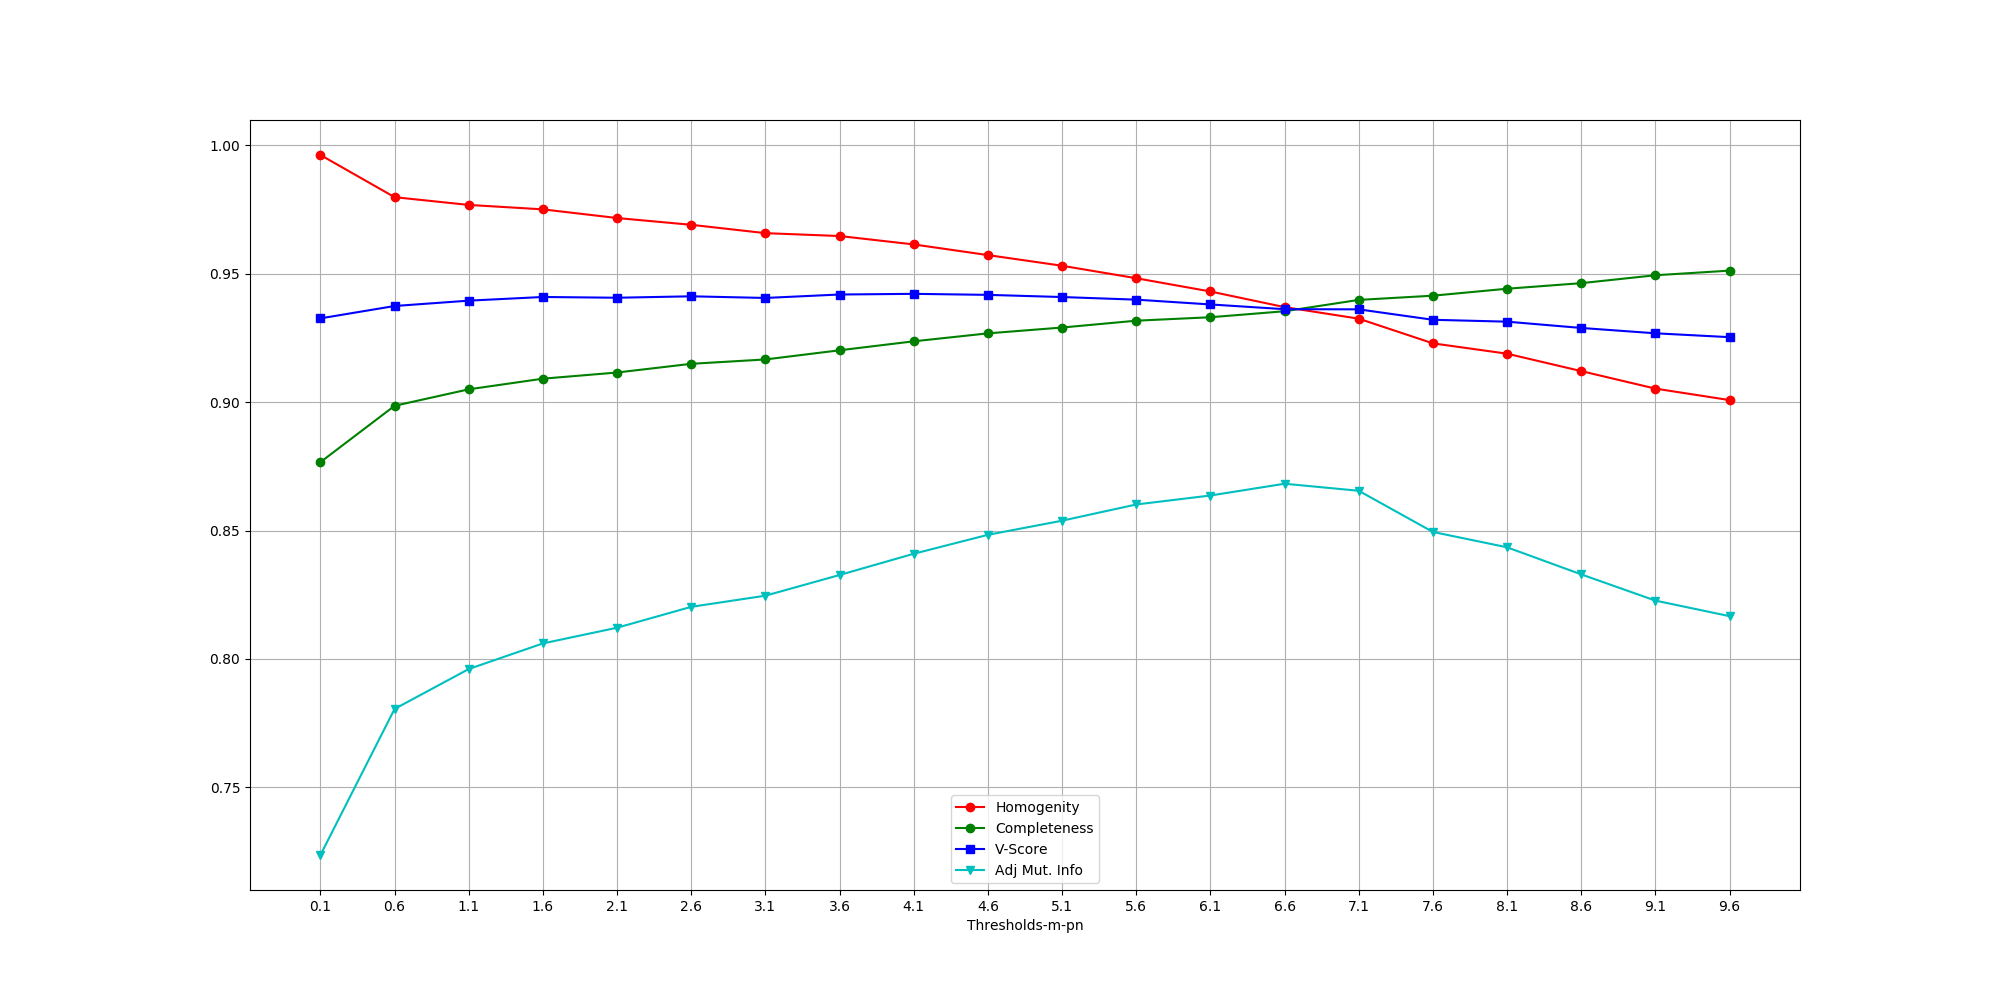

In [43]:
cluster_plot_file = join_path(experiment_outdir, "%s_clustering_homog-compl-vscore.png"%cluster_alg)
plot(cluster_results, x_row=0, x_label="Thresholds-%s"%run_tag, x_tick_step=1, 
     y_rows=[0,1,2, 4], y_labels=["Homogenity","Completeness", "V-Score", "Adj Mut. Info"],y_markers=["o","o","s","v"],y_colors=["r","g","b","c"], 
     cluster_plot_file= cluster_plot_file )
Image(filename=cluster_plot_file) 